In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torchvision.models as models

In [ ]:
### Downloading pretrained model
model=models.vgg16(pretrained=True)

/home/sachchida/anaconda3/envs/torch-cuda12_8/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sachchida/anaconda3/envs/torch-cuda12_8/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/sachchida/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:29<00:00, 18.8MB/s] 


In [ ]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
train_transform=transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
test_transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [ ]:
dataset_path="./data/flowers"
train_dataset=torchvision.datasets.ImageFolder(root=dataset_path+"/train",transform=train_transform)
test_dataset=torchvision.datasets.ImageFolder(root=dataset_path+"/test",transform=test_transform)
validate_dataset=torchvision.datasets.ImageFolder(root=dataset_path+"/valid",transform=test_transform)

In [16]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(validate_dataset,batch_size=32,shuffle=True)

In [ ]:
### Load class labels Freeze the existing layers except last fully connected dense layer
for params in model.features.parameters():
    params.requires_grad=False
num_features=model.classifier[6].in_features ##-Extract in_features from existing model
model.classifier[6]=nn.Linear(num_features,len(train_dataset.classes)) ### replace the no of classes from 1000 to desired classes needed in our dataset

In [22]:
from torchsummary import summary
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.classifier[6].parameters(),lr=0.001)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device=device)
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [23]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    train_losses, val_losses, val_accuracies = [], [], []
    best_accuracy = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.4f}")

        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Best model saved")

    return train_losses, val_losses, val_accuracies


### Start training

In [18]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

Epoch 1/22 | Train Loss: 0.2079 | Val Loss: 0.1526 | Val Acc: 0.9231
✅ Best model saved
Epoch 2/22 | Train Loss: 0.2058 | Val Loss: 0.1943 | Val Acc: 0.9203
Epoch 3/22 | Train Loss: 0.2386 | Val Loss: 0.2233 | Val Acc: 0.9093
Epoch 4/22 | Train Loss: 0.2124 | Val Loss: 0.1669 | Val Acc: 0.9313
✅ Best model saved
Epoch 5/22 | Train Loss: 0.1891 | Val Loss: 0.1785 | Val Acc: 0.9341
✅ Best model saved
Epoch 6/22 | Train Loss: 0.1999 | Val Loss: 0.2071 | Val Acc: 0.9231
Epoch 7/22 | Train Loss: 0.1898 | Val Loss: 0.1957 | Val Acc: 0.9148
Epoch 8/22 | Train Loss: 0.1989 | Val Loss: 0.1403 | Val Acc: 0.9396
✅ Best model saved
Epoch 9/22 | Train Loss: 0.1698 | Val Loss: 0.1751 | Val Acc: 0.9258
Epoch 10/22 | Train Loss: 0.1918 | Val Loss: 0.2001 | Val Acc: 0.9258
Epoch 11/22 | Train Loss: 0.1767 | Val Loss: 0.1626 | Val Acc: 0.9451
✅ Best model saved
Epoch 12/22 | Train Loss: 0.2072 | Val Loss: 0.1500 | Val Acc: 0.9286
Epoch 13/22 | Train Loss: 0.2109 | Val Loss: 0.1642 | Val Acc: 0.9313
Epoc

Text(0.5, 1.0, 'Accurracy Trend')

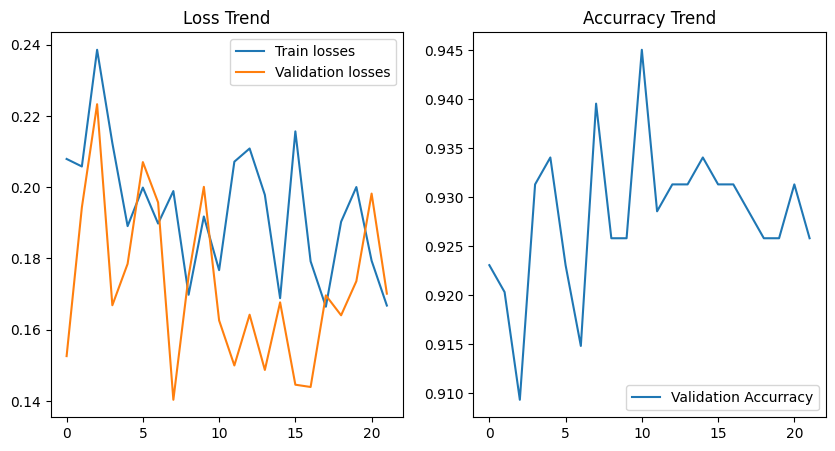

In [26]:
train_losses,val_losses,val_accurracies=train_model(model,train_loader=train_loader,val_loader=val_loader,criterion=criterion,optimizer=optimizer,device=device,epochs=22)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses,label='Train losses')
plt.plot(val_losses,label='Validation losses')
plt.legend()
plt.title('Loss Trend')

plt.subplot(1,2,2)
plt.plot(val_accurracies,label='Validation Accurracy')
plt.legend()
plt.title('Accurracy Trend')

In [31]:
def infer(image_path,model):
    image=Image.open(image_path).convert("RGB")
    image=test_transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output=model(image)
    probabilities=torch.nn.functional.softmax(output[0],dim=0)
    k=min(5,probabilities.size(0))
    top5_prob,top5_catid=probabilities.topk(k)
    results=[(train_dataset.classes[catid],prob.item()) for catid,prob in zip(top5_catid,top5_prob)]
    return results


In [28]:
from PIL import Image
import matplotlib.pyplot as plt

def show_image(image_path):
    image=Image.open(image_path)
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    

In [29]:
image_path_1=dataset_path+"/valid/daisy/5673551_01d1ea993e_n_jpg.rf.67903e6adc78b5d3de2a898c82911350.jpg"
image_path_2=dataset_path+"/valid/daisy/2454280135_ac3aa75cdc_n_jpg.rf.887628306390369ec097b003e3f1ce53.jpg"
image_path_3=dataset_path+"/valid/dandelion/136999986_e410a68efb_n_jpg.rf.502dc43fd285faeef9c89ffe63f5a520.jpg"
image_path_4=dataset_path+"/valid/dandelion/4552571121_2677bcdec3_jpg.rf.c205a14542abf77e23076c779be1aa30.jpg"

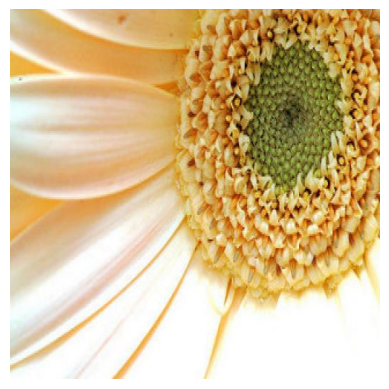

daisy: 0.9999
dandelion: 0.0001


In [32]:
show_image(image_path=image_path_1)
results=infer(image_path=image_path_1,model=model)
for label,prob in results:
    print(f"{label}: {prob:.4f}")

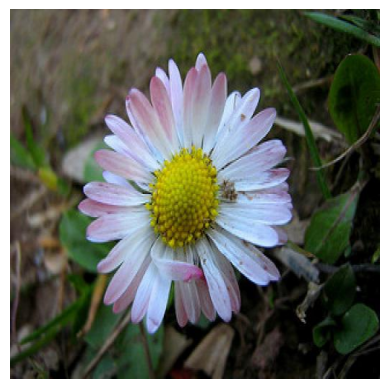

daisy: 0.9997
dandelion: 0.0003


In [33]:
image_path=image_path_2
show_image(image_path=image_path)
results=infer(image_path=image_path,model=model)
for label,prob in results:
    print(f"{label}: {prob:.4f}")

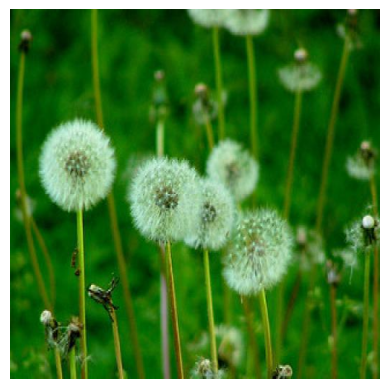

dandelion: 0.8080
daisy: 0.1920


In [34]:
image_path=image_path_3
show_image(image_path=image_path)
results=infer(image_path=image_path,model=model)
for label,prob in results:
    print(f"{label}: {prob:.4f}")

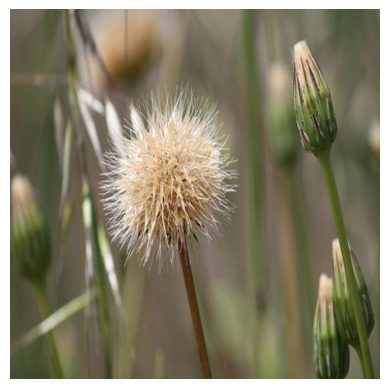

dandelion: 0.9991
daisy: 0.0009


In [35]:
image_path=image_path_4
show_image(image_path=image_path)
results=infer(image_path=image_path,model=model)
for label,prob in results:
    print(f"{label}: {prob:.4f}")